***

# **STA 221 Project Code**

***

## EDA

In [108]:
# packages

import time
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# For Wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

import string
import re
from collections import Counter

# Logistic Regression 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import plotly.express as px

In [109]:
tweets = pd.read_csv("Tweets.csv")

In [110]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Cleaning

In [111]:
# Cleaning http links in Dataframes
url_pattern = r'http[s]?://\S+'

# Replace URLs with an empty string
tweets['text'] = tweets['text'].str.replace(url_pattern, '', regex=True)
#tweets[tweets["text"].str.contains("http")]
#tweets.shape

tweets.drop_duplicates(subset = "text", keep = "last", inplace = True)

### Graphs

In [112]:
# Company Logo color (or at least one of them) is mapped to each Airline respetively.
color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

# Plotting number of tweets per each sentiment per each airline
px.histogram(
    data_frame=tweets,
    x="airline_sentiment",
    color="airline",
    title="Sentiment Labels of Tweets by Airlines",
    labels={"airline_sentiment": "Sentiment of Tweet"},
    color_discrete_map=color_discrete_map,
).update_xaxes(categoryorder = "total descending")

In [113]:
# Retweets are very 0 inflated
px.histogram(data_frame=tweets,
    x="retweet_count")

In [114]:
# Looking at Reason per airline for all negative reviews
px.histogram(
    data_frame=tweets,
    x="negativereason",
    color="airline",
    title="Reason for Negative Tweets by Airline",
    labels={"negativereason": "Reason for Negative Tweet"},
    color_discrete_map=color_discrete_map,  
).update_xaxes(categoryorder = "total descending")

### WordCloud

In [115]:
# Get one list
tweet_list = tweets["text"].tolist()

# Combine all tweets into a single string
all_tweets = " ".join(tweet_list)

# Load the plane image
plane_mask = np.array(Image.open("plane_image2.jpg"))

# color_list = np.array(['#b5d6e0',  '#ffef7a', '#f7c16a', '#ff6b3e', '#27214e'])

# Define a list of words to exclude
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(
    [
        "the",
        "and",
        "to",
        "of",
        "a",
        "in",
        "for",
        "on",
        "is",
        "with",
        "that",
        "by",
        "this",
        "it",
        "as",
        "are",
        "be",
        "was",
        "from",
        "at",
        "will",
        "your",
        "but",
        "http",
        "you",
    ]
)

# Create a WordCloud object
# wordcloud_im = WordCloud(stopwords=stopwords, background_color='white', mask=plane_mask, color_func=color_list, width=1000, height=1000, max_words=125).generate(all_tweets)

# Plot the WordCloud image
# plt.figure(figsize=(10, 10), facecolor=None)
# plt.imshow(wordcloud_im)
# plt.axis("off")
# plt.tight_layout(pad=0)


# Save or display the image
# plt.savefig('tweet_wordcloud.png')
# plt.show()

# Lets do this by Sentiment, since this doesnt tell us much

In [116]:
def count_frequent_words(s, min_count=10):
    # Remove words that start with 'http'
    s = re.sub(r"\bhttp\S*", "", s)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = s.lower().translate(str.maketrans("", "", string.punctuation))

    # Split the string into words
    words = normalized_string.split()

    # Count words and filter those that appear at least 'min_count' times
    word_count = Counter(words)


    frequent_words = {
        word: count for word, count in word_count.items() if count >= min_count
    }

    # Get the number of unique words that show up greater than or equal too min count
    num_unique_words = len(set(frequent_words))

    return num_unique_words, frequent_words

def talk_clean_to_me(string_vec):
    # Remove words that start with 'http'
    string_vec = re.sub(r"\bhttp\S*", "", string_vec)

    # Normalize the string: convert to lowercase and remove punctuation
    normalized_string = string_vec.lower().translate(str.maketrans("", "", string.punctuation))

    return string_vec

#count_frequent_words(all_tweets_pos)[0]

#talk_clean_to_me(all_tweets_pos)

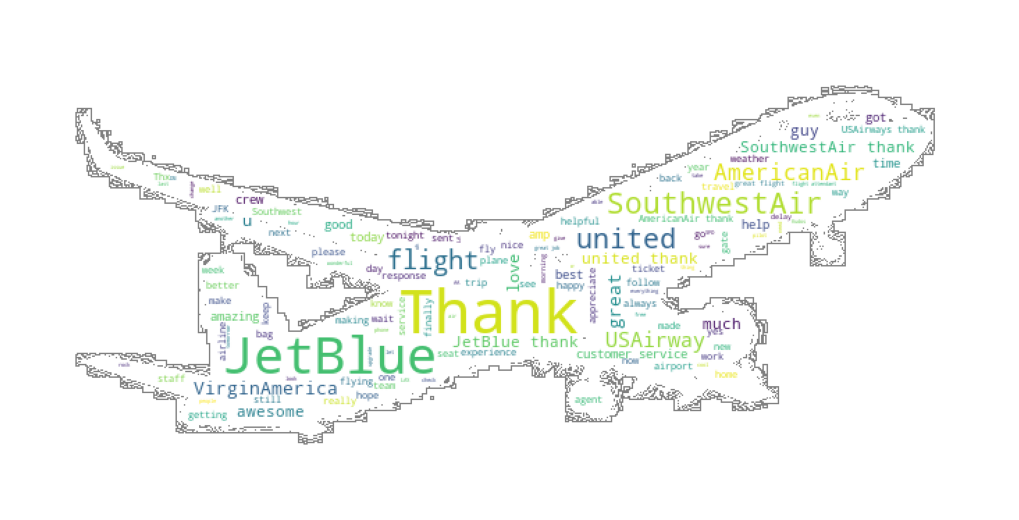

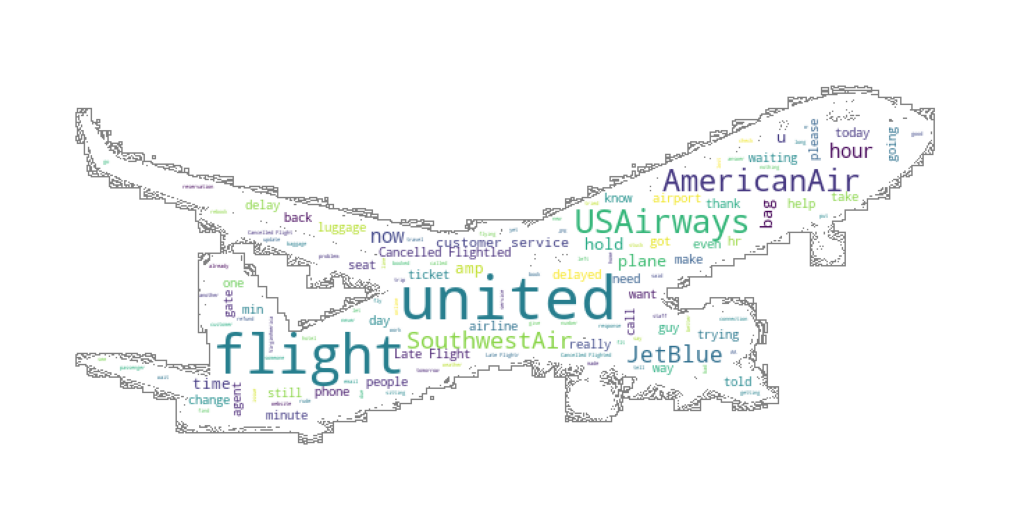

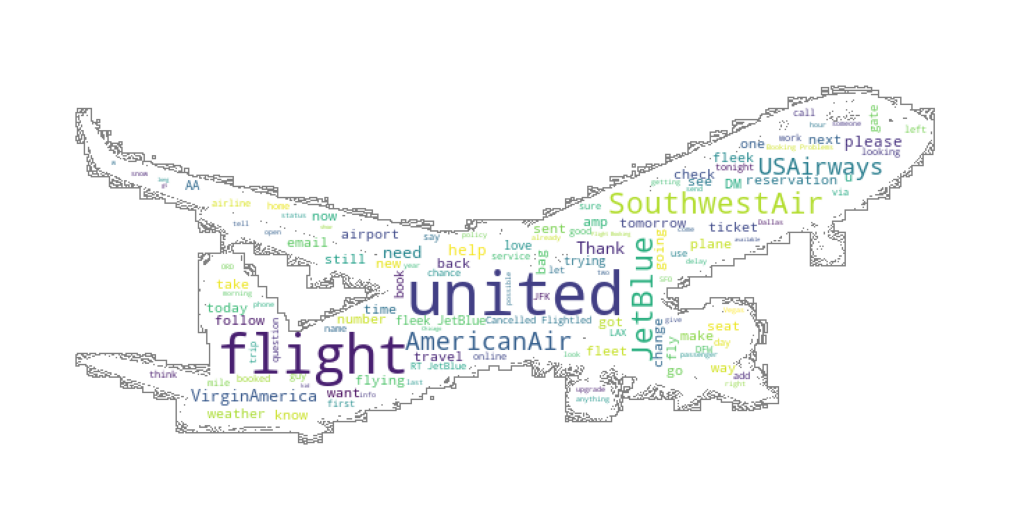

In [117]:
tweet_list_pos = tweets.loc[tweets["airline_sentiment"] == "positive", "text"]

all_tweets_pos = " ".join(tweet_list_pos)
all_tweets_pos = talk_clean_to_me(all_tweets_pos)

# Create a WordCloud object
wordcloud_im_pos = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    width=1000,
    height=1000,
    max_words=125,
).generate(all_tweets_pos)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_pos)
plt.axis("off")
plt.tight_layout(pad=0)


### Negative

tweet_list_neg = tweets.loc[tweets["airline_sentiment"] == "negative", "text"]

all_tweets_neg = " ".join(tweet_list_neg)

# Create a WordCloud object
wordcloud_im_neg = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neg)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neg)
plt.axis("off")
plt.tight_layout(pad=0)

### Neutral
tweet_list_neu = tweets.loc[tweets["airline_sentiment"] == "neutral", "text"]

all_tweets_neu = " ".join(tweet_list_neu)

# Create a WordCloud object
wordcloud_im_neu = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neu)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neu)
plt.axis("off")
plt.tight_layout(pad=0)

# Classification

### Binary Logistic Regression

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

# Only getting Binary labels
X = vectorizer.fit_transform(tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'text'])
y = tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.9098504837291117
              precision    recall  f1-score   support

    negative       0.91      0.99      0.95      1822
    positive       0.92      0.60      0.72       452

    accuracy                           0.91      2274
   macro avg       0.91      0.79      0.84      2274
weighted avg       0.91      0.91      0.90      2274



In [119]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a mapping of words to their coefficients
word_importance = dict(zip(feature_names, coefficients))

# Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the most influential words
#for word, coef in sorted_words[:10]:  # Adjust the number to display as needed
#    print(f"{word}: {coef}")

    # Sort words by the absolute values of their coefficients
sorted_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Convert the sorted words and coefficients into a DataFrame
df_word_importance = pd.DataFrame(sorted_words, columns=['Word', 'Coefficient'])

# Display the DataFrame
print(df_word_importance.head(50))  # Adjust the number to display as needed

             Word  Coefficient
0          thanks     8.335329
1           thank     8.332756
2           great     5.493345
3            love     4.318089
4         awesome     4.211748
5             not    -4.029247
6            best     3.905758
7              no    -3.718366
8         jetblue     3.492744
9         amazing     3.375404
10           good     3.352262
11          hours    -3.310579
12          worst    -3.299650
13            thx     3.034400
14          kudos     3.028152
15   southwestair     2.942749
16        delayed    -2.880786
17      cancelled    -2.872229
18  virginamerica     2.862673
19      excellent     2.706022
20        worries     2.647964
21           hold    -2.625305
22     appreciate     2.397719
23            why    -2.327319
24      wonderful     2.313847
25        luggage    -2.274237
26           hour    -2.187061
27        nothing    -2.168016
28           nice     2.075313
29            can    -2.065326
30            don    -2.042110
31      

### Logistic Regression with L1 Penalty

In [140]:
# 'liblinear' is a good choice for small datasets, while 'saga' is faster for larger ones
model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9133685136323659
              precision    recall  f1-score   support

    negative       0.92      0.97      0.95      1822
    positive       0.87      0.67      0.75       452

    accuracy                           0.91      2274
   macro avg       0.89      0.82      0.85      2274
weighted avg       0.91      0.91      0.91      2274



In [141]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {feature: coef for feature, coef in feature_importance.items() if coef != 0}

# Convert to DataFrame
df_significant_features = pd.DataFrame(list(significant_features.items()), columns=['Feature', 'Coefficient'])

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(df_significant_features['Coefficient'].abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
print(df_significant_features.head(10))


       Feature  Coefficient
266      thank    13.722481
268     thanks    12.341288
111      great     9.115046
149      kudos     8.604189
129      hours    -8.600794
313    worries     8.486291
314      worst    -8.465061
25     awesome     8.184880
163       love     7.727225
77   excellent     7.691274


In [142]:
#X.toarray().shape
#df_significant_features["Feature"]

# Extract only the significant features
significant_feature_names = list(significant_features.keys())

# Assuming 'vectorizer' is your original vectorizer and 'X' is the original feature matrix
#X_filtered = X[:, vectorizer.get_feature_names_out().isin(significant_feature_names)]
#X_filtered

X_filtered = X[:, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)]

In [143]:
### Now we use the standard Logistic regression model only using the words chosen by LASSO

# Filter the original feature matrix
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
model_filtered = LogisticRegression(random_state=42)

# Train the model
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9045734388742305
              precision    recall  f1-score   support

    negative       0.90      0.98      0.94      1822
    positive       0.90      0.58      0.71       452

    accuracy                           0.90      2274
   macro avg       0.90      0.78      0.83      2274
weighted avg       0.90      0.90      0.90      2274



In [124]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains categorical labels like 'positive', 'negative'
# Assuming X_train and y_train are your features and target variable

# Initialize the LabelEncoder
#label_encoder = LabelEncoder()

# Fit and transform the labels to numeric
#y_train_encoded = label_encoder.fit_transform(y_train)

# Convert the sparse matrix to a dense array
#X_train_dense = X_train.toarray()

# Add a constant to the features
#X_train_sm = sm.add_constant(X_train_dense)

# Fit the model
#model_sm = sm.Logit(y_train_encoded, X_train_sm).fit()

# Display the summary
#print(model_sm.summary())

### Logistic Regression with Elastic Net Penalty

In [144]:
model = LogisticRegression(
    penalty="elasticnet", l1_ratio=0.9, C=1.0, solver="saga", random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.911169744942832
              precision    recall  f1-score   support

    negative       0.92      0.98      0.95      1822
    positive       0.87      0.65      0.74       452

    accuracy                           0.91      2274
   macro avg       0.89      0.81      0.84      2274
weighted avg       0.91      0.91      0.91      2274



In [145]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {
    feature: coef for feature, coef in feature_importance.items() if coef != 0
}

# Convert to DataFrame
df_significant_features = pd.DataFrame(
    list(significant_features.items()), columns=["Feature", "Coefficient"]
)

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(
    df_significant_features["Coefficient"].abs().sort_values(ascending=False).index
)

# Display the sorted DataFrame
print(df_significant_features.head(10))

     Feature  Coefficient
308    thank    12.542269
310   thanks    11.504966
131    great     8.328271
27   awesome     7.247139
191     love     6.968579
175    kudos     6.895998
152    hours    -6.740731
367  worries     6.564591
368    worst    -6.494294
38      best     6.028031


In [146]:
# Extract only the significant features
significant_feature_names = list(significant_features.keys())

X_filtered = X[
    :, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)
]

## Now we use the standard Logistic regression model only using the words chosen by Elastic Net

# Filter the original feature matrix
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
model_filtered = LogisticRegression(random_state=42)

# Train the model
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9058927000879508
              precision    recall  f1-score   support

    negative       0.91      0.98      0.94      1822
    positive       0.90      0.59      0.71       452

    accuracy                           0.91      2274
   macro avg       0.90      0.79      0.83      2274
weighted avg       0.91      0.91      0.90      2274



In [127]:
df_significant_features

,Feature,Coefficient
308,thank,12.542269
310,thanks,11.504966
131,great,8.328271
27,awesome,7.247139
191,love,6.968579
...,...,...
173,kind,0.015547
315,think,-0.009563
268,safety,0.008509
373,yet,-0.006751


### Logistic Regression with N-Grams

In [165]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True, ngram_range=(1,2))

# Only getting Binary labels
X = vectorizer.fit_transform(tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'text'])
y = tweets.loc[(tweets["airline_sentiment"] == "positive") | (tweets["airline_sentiment"] == "negative"), 'airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.9001759014951627
              precision    recall  f1-score   support

    negative       0.90      0.99      0.94      1822
    positive       0.91      0.55      0.69       452

    accuracy                           0.90      2274
   macro avg       0.90      0.77      0.81      2274
weighted avg       0.90      0.90      0.89      2274



#### N-Gram LASSO

In [170]:
# 'liblinear' is a good choice for small datasets, while 'saga' is faster for larger ones
model = LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter= 20000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model,
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.905452946350044
              precision    recall  f1-score   support

    negative       0.91      0.97      0.94      1822
    positive       0.86      0.63      0.73       452

    accuracy                           0.91      2274
   macro avg       0.88      0.80      0.83      2274
weighted avg       0.90      0.91      0.90      2274



In [171]:
# Get the coefficients
coefficients = model.coef_[0]

# Map coefficients to features
feature_importance = dict(zip(feature_names, coefficients))

# Filter out features with zero coefficients
significant_features = {
    feature: coef for feature, coef in feature_importance.items() if coef != 0
}

# Convert to DataFrame
df_significant_features = pd.DataFrame(
    list(significant_features.items()), columns=["Feature", "Coefficient"]
)

# Order by the absolute value of the coefficients
df_significant_features = df_significant_features.reindex(
    df_significant_features["Coefficient"].abs().sort_values(ascending=False).index
)

# Display the sorted DataFrame
print(df_significant_features.head(10))


# Extract only the significant features
significant_feature_names = list(significant_features.keys())

X_filtered = X[
    :, np.isin(vectorizer.get_feature_names_out(), significant_feature_names)
]

### Now we use the standard Logistic regression model only using the words chosen by LASSO

# Filter the original feature matrix
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
model_filtered = LogisticRegression(random_state=42)

# Train the model
model_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = model_filtered.predict(X_test_filtered)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

         Feature  Coefficient
19            fb    10.532439
59        status     9.270402
11        bummer     8.883485
37          like    -8.187085
27         hates     7.961943
48         price    -6.310221
15  disconnected     5.881800
61        stinks     5.544731
36          life     5.366972
50          race     4.900342
Accuracy: 0.8016710642040458
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89      1822
    positive       1.00      0.00      0.00       452

    accuracy                           0.80      2274
   macro avg       0.90      0.50      0.45      2274
weighted avg       0.84      0.80      0.71      2274



### Logistic Regression with Combined Positive and Neutral Class to Address Class Imbalance

In [149]:
# Trying to combine labels of positive and neutral
tweets_comb = tweets.copy()
tweets_comb["airline_sentiment"] = tweets_comb["airline_sentiment"].replace(
    {"neutral": "positive + neutral", "positive": "positive + neutral"}
)

### Standard Logistic Regression

In [153]:
# Only getting Binary labels
X = vectorizer.fit_transform(tweets_comb['text'])
y = tweets_comb['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8364583333333333
                    precision    recall  f1-score   support

          negative       0.84      0.91      0.87      1791
positive + neutral       0.83      0.71      0.77      1089

          accuracy                           0.84      2880
         macro avg       0.83      0.81      0.82      2880
      weighted avg       0.84      0.84      0.83      2880



Less accuracy does not make this of interest to pursuit, might revisit in the future. 

### Multinomial Regression 

In [154]:
# Only getting Trinary labels
X = vectorizer.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", random_state = 42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.79375
              precision    recall  f1-score   support

    negative       0.82      0.94      0.87      1791
     neutral       0.68      0.51      0.58       636
    positive       0.82      0.60      0.70       453

    accuracy                           0.79      2880
   macro avg       0.77      0.69      0.72      2880
weighted avg       0.79      0.79      0.78      2880



c:\Users\Gianni\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Multinomial Logistic Regression with L1 Penalty

In [157]:
# Only getting Trinary labels
X = vectorizer.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(penalty = "l1", multi_class = "multinomial", solver = "saga", random_state = 42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7875
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1791
     neutral       0.66      0.52      0.58       636
    positive       0.79      0.61      0.69       453

    accuracy                           0.79      2880
   macro avg       0.76      0.69      0.71      2880
weighted avg       0.78      0.79      0.78      2880



### SVM

In [128]:
# SVM | https://medium.com/scrapehero/sentiment-analysis-using-svm-338d418e3ff1

train_vectors = vectorizer.fit_transform(tweets["text"])
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel="linear")
t0 = time.time()
classifier_linear.fit(train_vectors, tweets["airline_sentiment"])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1 - t0
time_linear_predict = t2 - t1
# results
print(
    "Training time: %fs; Prediction time: %fs"
    % (time_linear_train, time_linear_predict)
)
report = classification_report(testData["Label"], prediction_linear, output_dict=True)
print("positive: ", report["pos"])
print("negative: ", report["neg"])

NameError: name 'test_vectors' is not defined

In [ ]:
# https://www.educative.io/answers/how-to-use-svm-for-sentiment-analysis

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


text = tweets["text"].values
labels = tweets["airline_sentiment"].values

text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(text_train)
features_test = vectorizer.transform(text_test)

svm = SVC(kernel="linear")
svm.fit(features_train, labels_train)

predictions = svm.predict(features_test)
new_text = [
    "I hate Devin Booker",
    "Thai Canteen has awful service.",
    "The new Titebond glue is amazing.",
]
new_features = vectorizer.transform(new_text)
new_predictions = svm.predict(new_features)
print(new_predictions)

# Step 7: Generate the classification report to evaluate the model
print(classification_report(labels_test, predictions))

['negative' 'neutral' 'positive']
              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1889
     neutral       0.58      0.56      0.57       580
    positive       0.70      0.71      0.71       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [ ]:
# https://www.kaggle.com/code/lbronchal/sentiment-analysis-with-svm

data_clean = tweets[tweets["airline_sentiment_confidence"] > 0.65]
data_clean["sentiment"] = data_clean["airline_sentiment"].apply(
    lambda x: 1 if x == "negative" else 0
)

data_clean["text_clean"] = data_clean["text"].apply(
    lambda x: BeautifulSoup(x, "lxml").text
)